# Setup

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

from typing import List
from typing_extensions import TypedDict
from IPython.display import Image, display
from langchain.schema import Document
from langgraph.graph import START, END, StateGraph

# Llama3: 8 billion params model running on Ollama
LLM_MODEL_NAME = "llama3"

%load_ext dotenv
%dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


# Initializing In-memory Vector Store & Retriever

Using Langchain's SKLearnVectoreStore to initialize a minimal vectorstore and use as the retriever  

In [3]:
# Setup documents and generate doc splits
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=250, chunk_overlap=0)
doc_splits = text_splitter.split_documents(docs_list)

# Embeddings
embedding = NomicEmbeddings(
    model="nomic-embed-text-v1.5",
    inference_mode="local",
    device="gpu"
)

# Finally, create the vectorstore and Retriever
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=embedding,
)
retriever = vectorstore.as_retriever(k=4)

# Tools required for making RAG applications "Corrective"

## Retrieval Evaluator

In [13]:
# Using Llama3:8b as the evaluator, as T5 was crashing on my machine
evaluator_llm = ChatOllama(model=LLM_MODEL_NAME, format="json", temperature=0)

# Prompt
evaluator_prompt = PromptTemplate(
    template="""You are a teacher grading a quiz. You will be given: 
    1/ a QUESTION
    2/ A FACT provided by the student
    
    You are grading RELEVANCE RECALL:
    A score of 1 means that ANY of the statements in the FACT are relevant to the QUESTION. 
    A score of 0 means that NONE of the statements in the FACT are relevant to the QUESTION. 
    1 is the highest (best) score. 0 is the lowest score you can give. 
    
    Explain your reasoning in a step-by-step manner. Ensure your reasoning and conclusion are correct. 
    
    Avoid simply stating the correct answer at the outset.
    
    Question: {question} \n
    Fact: \n\n {documents} \n\n
    
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.
    """,
    input_variables=["question", "documents"],
)

retrieval_evaluator_chain = evaluator_prompt| evaluator_llm | JsonOutputParser()

In [14]:
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_evaluator_chain.invoke({"question": question, "documents": doc_txt}))

{'score': 1}


In [6]:
docs

[Document(metadata={'id': '9fcb6efe-6226-4340-a7c8-3cdde16a1cbf', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='They also discussed the risks, especially with illicit drugs and bioweapons. They developed a test set containing a list of known chemical weapon agents and asked the agent to synthesize them. 4 out of 11 requests (36%) were accepted to obtain a synthesis solution and the 

## Knowledge Searching - Web Search Using Tavily API

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# RAG Application Components

In [15]:
# Generate response from LLM

# Prompt
generation_prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks. 
    
    Use the following documents to answer the question. 
    
    If you don't know the answer, just say that you don't know. 
    
    Use three sentences maximum and keep the answer concise:
    Question: {question} 
    Documents: {documents} 
    Answer: 
    """,
    input_variables=["question", "documents"],
)

# LLM
generation_llm = ChatOllama(model=LLM_MODEL_NAME, temperature=0)

# Chain
generation_chain = generation_prompt | generation_llm | StrOutputParser()

In [17]:
# Run
_generation = generation_chain.invoke({"documents": docs, "question": question})
print(_generation)

According to the documents, agent memory refers to the long-term memory module that records a comprehensive list of agents' experience in natural language. This allows the agent to retain and recall information over extended periods. Additionally, there is also short-term memory which is utilized for in-context learning, and sensory memory which learns embedding representations for raw inputs.


## RAG State data structures

In [11]:
class BasicGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    steps: List[str]

In [9]:
class CorrectiveGraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]

## Basic RAG - Nodes logic

In [18]:
def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = generation_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


## Basic RAG LangGraph

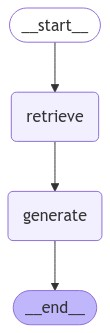

In [19]:
basic_rag_workflow = StateGraph(BasicGraphState)

# Define nodes
basic_rag_workflow.add_node("retrieve", retrieve)
basic_rag_workflow.add_node("generate", generate)

# Build Graph
basic_rag_workflow.add_edge(START, "retrieve")
basic_rag_workflow.add_edge("retrieve", "generate")
basic_rag_workflow.add_edge("generate", END)

basic_rag_graph = basic_rag_workflow.compile()

display(Image(basic_rag_graph.get_graph(xray=True).draw_mermaid_png()))

## Corrective RAG LangGraph

In [22]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_evaluator_chain.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"

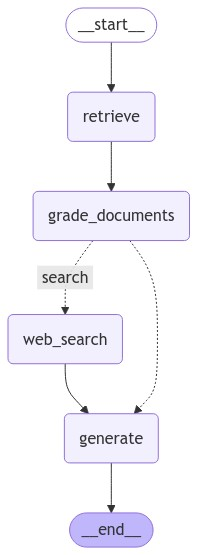

In [23]:
corrective_rag_workflow = StateGraph(CorrectiveGraphState)

# Define the nodes
corrective_rag_workflow.add_node("retrieve", retrieve)  # retrieve
corrective_rag_workflow.add_node("grade_documents", grade_documents)  # grade documents
corrective_rag_workflow.add_node("generate", generate)  # generatae
corrective_rag_workflow.add_node("web_search", web_search)  # web search

# Build graph
corrective_rag_workflow.add_edge(START, "retrieve")
corrective_rag_workflow.add_edge("retrieve", "grade_documents")
corrective_rag_workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
corrective_rag_workflow.add_edge("web_search", "generate")
corrective_rag_workflow.add_edge("generate", END)  

corrective_rag_graph = corrective_rag_workflow.compile()

display(Image(corrective_rag_graph.get_graph(xray=True).draw_mermaid_png()))

# Evaluation

In [47]:
import uuid

def _generate_response(rag_type: str, question: dict):
    config = {
        "configurable": {"thread_id": rag_type.upper() + uuid.uuid4().hex},
    }
    _graph = basic_rag_graph if rag_type == "basic" else corrective_rag_graph    
    state_dict = _graph.invoke(
        {"question": question["input"], "steps": []}, config
    )
    return state_dict

def _format_responses(rag_type: str, state_dict: dict):
    print(f"{rag_type.upper()}: {state_dict['steps']}")
    print(state_dict["generation"])


def compare_the_rags(question: dict):
    _format_responses("basic", _generate_response("basic", question))
    print("\n" + "-"*150 + "\n")
    _format_responses("corrective", _generate_response("corrective", question))


In [44]:
example = {"input": "What are the types of agent memory?"}

compare_the_rags(example)

BASIC: ['retrieve_documents', 'generate_answer']
According to the documents, there are several types of memory:

* Sensory Memory: retains impressions of sensory information (visual, auditory, etc) after the original stimuli have ended.
* Short-term Memory: provides in-context learning and is short and finite, restricted by the finite context window length of Transformer.

These types of memory can be used to enable agents to behave conditioned on past experience.
------------------------------


CORRECTIVE: ['retrieve_documents', 'grade_document_retrieval', 'web_search', 'generate_answer']
According to the provided documents, there are different high-level types of memory for agents, including:

* Short-term memory for context
* Long-term memory using external storage, such as vector databases
* Contextual memory

These types of memory enable efficient information retrieval and enhanced reasoning in AI agents.


In [30]:
_generate_response("corrective", example)

{'question': 'What are the types of agent memory?',
 'generation': 'According to the provided documents, there are different types of agent memory mentioned:\n\n* Short-term memory for context and long-term memory using external storage (Document 2)\n* High-level types of memory, including [not specified] (Document 1)\n\nThese types of memory enable agents to provide more personalized and efficient interactions.',
 'search': 'Yes',
 'documents': [Document(metadata={'url': 'https://blog.langchain.dev/memory-for-agents/'}, page_content='Memory for agents Memory for agents At Sequoia’s AI Ascent conference in March, I talked about three limitations for agents: planning, UX, and memory. But what even is memory? While the exact shape of memory that your agent has may differ by application, we do see different high level types of memory. Below is my rough, ELI5 explanation of each type and practical ways for how todays agents may use and update this memory type. Besides just thinking about t